In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from wsfr_read.streamflow import read_usgs_streamflow_data
from wsfr_read import teleconnections
from geopy.distance import geodesic
import copy
import os
import json

2023-12-12 22:28:36.509 | INFO     | wsfr_read.config:<module>:9 - DATA_ROOT is D:\WaterForecast\data


In [2]:
df = pd.read_csv('./data/train.csv')

def generate_dates(year):
    dates = []
    for month in range(1, 8):  # January to July
        for day in [1, 8, 15, 22]:
            dates.append(datetime(year, month, day))
    return dates
df = df[df['year'] >= 1990]
df['issue_date'] = df['year'].apply(generate_dates)
df = df.explode('issue_date')

In [3]:
# Scale the Data
scalers = {}
def min_max_scale_volume(group):
    site_id = group.name
    scaler = MinMaxScaler()
    group['volume_scaled']= scaler.fit_transform(group[['volume']])
    scalers[site_id] = scaler 
    return group
df_scaled = df.groupby('site_id').apply(min_max_scale_volume)
df_scaled = df_scaled.reset_index(drop = True)
df_scaled

,site_id,year,volume,issue_date,volume_scaled
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628
...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856


In [4]:
unique_sites = df_scaled['site_id'].unique()
volumes = {}
for site in unique_sites:
    filtered_df = df_scaled[df_scaled['site_id'] == site]
    max_vol = filtered_df['volume'].max()
    min_vol = filtered_df['volume'].min()
    volumes[site] = {'max_vol': max_vol,'min_vol': min_vol}
with open('volume_dict.txt', 'w') as file:
    file.write(json.dumps(volumes, indent = 4))

# Nearest Sites

In [5]:
meta = pd.read_csv('./data/metadata.csv')
locations = meta.set_index('site_id')[['latitude', 'longitude']].T.apply(tuple).to_dict()

def calculate_distances(locations):
    distances = {site: {} for site in locations}
    for site1, coords1 in locations.items():
        for site2, coords2 in locations.items():
            if site1 != site2:
                lat_long_1 = (coords1['latitude'], coords1['longitude'])
                lat_long_2 = (coords2['latitude'], coords2['longitude'])
                distances[site1][site2] = geodesic(lat_long_1, lat_long_2).kilometers
    return distances

# Calculate distances
distances = calculate_distances(locations)

# Rank distances for each location and add to DataFrame
meta['ranked_site_id'] = meta['site_id'].apply(
    lambda x: [site for site, _ in sorted(distances[x].items(), key=lambda item: item[1])]
)
loc_dict = meta.set_index('site_id')['ranked_site_id'].to_dict()

In [6]:
# Dictionary contains site_ids ranked from nearest to furthest
loc_dict['san_joaquin_river_millerton_reservoir']

['merced_river_yosemite_at_pohono_bridge',
 'american_river_folsom_lake',
 'virgin_r_at_virtin',
 'owyhee_r_bl_owyhee_dam',
 'boise_r_nr_boise',
 'weber_r_nr_oakley',
 'detroit_lake_inflow',
 'fontenelle_reservoir_inflow',
 'snake_r_nr_heise',
 'animas_r_at_durango',
 'yampa_r_nr_maybell',
 'green_r_bl_howard_a_hanson_dam',
 'ruedi_reservoir_inflow',
 'taylor_park_reservoir_inflow',
 'boysen_reservoir_inflow',
 'dillon_reservoir_inflow',
 'missouri_r_at_toston',
 'sweetwater_r_nr_alcova',
 'stehekin_r_at_stehekin',
 'pecos_r_nr_pecos',
 'colville_r_at_kettle_falls',
 'skagit_ross_reservoir',
 'libby_reservoir_inflow',
 'pueblo_reservoir_inflow',
 'hungry_horse_reservoir_inflow']

# USGS StreamFlow Data

In [7]:
# Directory should be data/USGS_streamflow
curr_dir = './data/USGS_streamflow'
all_data = pd.DataFrame()
dfs_to_concat = []

# Iterate through each fiscal year folder
for fy in os.listdir(curr_dir):
    fy_path = os.path.join(curr_dir, fy)
    
    if os.path.isdir(fy_path):
        # Iterate through each CSV file in the fiscal year folder
        for file in os.listdir(fy_path):
            if file.endswith('.csv'):
                file_path = os.path.join(fy_path, file)
                stream_name = file.split(".")[0]
            
                df_temp = pd.read_csv(file_path)
                df_temp["site_id"] = stream_name
                df_temp = df_temp[["site_id", "00060_Mean", "datetime"]]
                    
                # Add to concat list
                dfs_to_concat.append(df_temp)

all_data = pd.concat(dfs_to_concat, ignore_index=True)
print("Concatenation Finished")

Concatenation Finished


In [8]:
all_data = all_data.rename(columns={"00060_Mean":"volume"})

usgs_scalers = {}
for site_id in all_data['site_id'].unique():
    scaler = MinMaxScaler()
    site_data = all_data[all_data['site_id'] == site_id]  # Filter data for the current site_id

    # Reshape data for scaling
    volumes = site_data['volume'].values.reshape(-1, 1)

    # Fit and transform the data
    scaled_volumes = scaler.fit_transform(volumes)

    # You can replace the original volume data in the DataFrame if desired
    all_data.loc[all_data['site_id'] == site_id, 'volume'] = scaled_volumes.flatten()

    # Store the scaler
    usgs_scalers[site_id] = scaler

all_sites = list(df_scaled['site_id'].unique())
all_data_sites = list(all_data['site_id'].unique())
remaining_sites = [site for site in all_sites if site not in all_data_sites]
all_data_dict = all_data.groupby('site_id').apply(lambda x: x.set_index('datetime')['volume'].to_dict()).to_dict()
all_timestamps = list(all_data['datetime'].unique())
new_site_data = {}
new_rows = []
# Add in data for missing timestamps
for timestamp in all_timestamps:
    for site,dic in all_data_dict.items():
        if timestamp not in dic:
            locs = [s for s in loc_dict[site] if s in all_data_sites]
            temp_lst = []
            for loc in locs:
                if timestamp in all_data_dict[loc]:
                    temp_lst.append(all_data_dict[loc][timestamp])
                    if len(temp_lst) == 3:
                        break
            vol = np.mean(temp_lst)
            all_data_dict[site][timestamp] = vol
            new_rows.append({'site_id': site,'volume': vol,'datetime': timestamp})

all_data = pd.concat([all_data, pd.DataFrame(new_rows)], ignore_index = True)
all_data = all_data.sort_values(by = ['site_id','datetime'])

# Add in data for remaining sites
for site in remaining_sites:
    locs = loc_dict[site]
    pop_locs = [loc for loc in locs if loc not in remaining_sites][:3]
    lst = []
    s1 = all_data_dict[pop_locs[0]].values()
    s2 = all_data_dict[pop_locs[1]].values()
    s3 = all_data_dict[pop_locs[2]].values()
    s_mean = [np.mean([x,y,z]) for x,y,z in zip(s1,s2,s3)]
    new_site_data[site]=[s_mean,all_timestamps]
new_site_data_flatten = []
for site_id, (volumes, timestamps) in new_site_data.items():
    for volume, timestamp in zip(volumes, timestamps):
        new_site_data_flatten.append([site_id, volume, timestamp])
new_site_data_df = pd.DataFrame(new_site_data_flatten,columns = ['site_id','volume','datetime'])
new_site_data_df
usgs_df = pd.concat([all_data, new_site_data_df], ignore_index = True)
usgs_df['datetime'] = pd.to_datetime(usgs_df['datetime']).dt.tz_convert('UTC').dt.tz_localize(None)
usgs_df

,site_id,volume,datetime
0,animas_r_at_durango,0.013762,1989-10-01
1,animas_r_at_durango,0.013887,1989-10-02
2,animas_r_at_durango,0.014638,1989-10-03
3,animas_r_at_durango,0.025157,1989-10-04
4,animas_r_at_durango,0.049825,1989-10-05
...,...,...,...
260099,skagit_ross_reservoir,0.030116,2023-07-17
260100,skagit_ross_reservoir,0.027592,2023-07-18
260101,skagit_ross_reservoir,0.027136,2023-07-19
260102,skagit_ross_reservoir,0.028084,2023-07-20


In [9]:
all_sites

['american_river_folsom_lake',
 'animas_r_at_durango',
 'boise_r_nr_boise',
 'boysen_reservoir_inflow',
 'colville_r_at_kettle_falls',
 'detroit_lake_inflow',
 'dillon_reservoir_inflow',
 'fontenelle_reservoir_inflow',
 'green_r_bl_howard_a_hanson_dam',
 'hungry_horse_reservoir_inflow',
 'libby_reservoir_inflow',
 'merced_river_yosemite_at_pohono_bridge',
 'missouri_r_at_toston',
 'owyhee_r_bl_owyhee_dam',
 'pecos_r_nr_pecos',
 'pueblo_reservoir_inflow',
 'ruedi_reservoir_inflow',
 'san_joaquin_river_millerton_reservoir',
 'skagit_ross_reservoir',
 'snake_r_nr_heise',
 'stehekin_r_at_stehekin',
 'sweetwater_r_nr_alcova',
 'taylor_park_reservoir_inflow',
 'virgin_r_at_virtin',
 'weber_r_nr_oakley',
 'yampa_r_nr_maybell']

In [10]:
def get_rolling_window(row, usgs_df):
    end_date = row['issue_date'] - pd.Timedelta(days=1)
    start_date = end_date - pd.Timedelta(days=29)
    site_id = row['site_id']
    
    filtered_data = usgs_df[(usgs_df['site_id'] == site_id) & (usgs_df['datetime'] >= start_date) & (usgs_df['datetime'] <= end_date)]

    return filtered_data['volume'].tolist()
df_scaled['usgs_rw'] = df_scaled.apply(lambda row: get_rolling_window(row, usgs_df), axis=1)
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,..."
...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17..."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1..."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31..."
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1..."


## Monthly Naturalized Flow

In [11]:
train_mnf = pd.read_csv('./data/train_monthly_naturalized_flow.csv')
train_mnf = train_mnf[train_mnf['forecast_year'] >= 1990]
test_mnf = pd.read_csv('./data/test_monthly_naturalized_flow.csv')
test_mnf = test_mnf[test_mnf['forecast_year'] >= 1990]
meta_start_end = meta.set_index('site_id')[['season_start_month', 'season_end_month']].T.apply(tuple).to_dict()
raw_df = pd.read_csv('./data/train.csv')

## Store the sum of start month to end month - 1 in a dictionary
seasonal_flows_train = {}
# seasonal_flows_test = {}
train_years = []
# test_years = []
for site_id, val in meta_start_end.items():
    start_month = val['season_start_month']
    end_month = val['season_end_month']
    site_data = train_mnf[train_mnf['site_id'] == site_id]
    test_site_data = test_mnf[test_mnf['site_id'] == site_id]
    season_data = site_data[(site_data['month'] >= start_month) & (site_data['month'] < end_month)]
    test_season_data = test_site_data[(test_site_data['month'] >= start_month) & (test_site_data['month'] < end_month)]
    # Train_data
    for year in season_data['year'].unique():
        # keep track of all the years in train data
        train_years = list(set(train_years + list(season_data['year'].unique())))
        # filter out by year
        yearly_data = season_data[season_data['year'] == year]
        # Check if all months in the range are present
        if site_id not in seasonal_flows_train.keys():
            seasonal_flows_train[site_id] = {}
        if len(yearly_data) < end_month - start_month or yearly_data['volume'].isna().sum()>0:
            seasonal_flows_train[site_id][year] = np.nan
        else:
            # Sum the flow values
            seasonal_flows_train[site_id][year] = yearly_data['volume'].sum()
    
    # # Test_data
    # for year in test_season_data['year'].unique():
    #     # keep track of all the years in test data
    #     test_years = list(set(test_years + list(test_season_data['year'].unique())))
    #     # filter out by year
    #     yearly_data = test_season_data[test_season_data['year'] == year]
    #     # Check if all months in the range are present
    #     if site_id not in seasonal_flows_test.keys():
    #         seasonal_flows_test[site_id] = {}
    #     if len(yearly_data) < end_month - start_month or yearly_data['volume'].isna().sum()>0:
    #         seasonal_flows_test[site_id][year] = np.nan
    #     else:
    #         # Sum the flow values
    #         seasonal_flows_test[site_id][year] = yearly_data['volume'].sum()

In [12]:
raw_df = pd.read_csv('./data/train.csv')
raw_df = raw_df[raw_df['year'] >= 1990]
def get_dict_value(row, seasonal_flows_train):
    site_id = row['site_id']
    year = row['year']
    return seasonal_flows_train.get(site_id, {}).get(year, None)
raw_df['last_volume'] = raw_df.apply(lambda row: row['volume'] - get_dict_value(row, seasonal_flows_train) if get_dict_value(row, seasonal_flows_train) is not None else np.nan, axis=1)

In [13]:
# Convert the raw monthly naturalized flow into dictionary to allow ease of adding data
train_nested_dict = {}
for ind, row in train_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    volume = row['volume']
    

    if site_id not in train_nested_dict:
        train_nested_dict[site_id] = {}
    if year not in train_nested_dict[site_id]:
        train_nested_dict[site_id][year] = {}

    train_nested_dict[site_id][year][month] = volume

# Add the last month's volume to the data
missing_site_ids = []
for ind, row in raw_df.iterrows():
    site_id = row['site_id']
    year = row['year']
    volume = row['last_volume']
    if site_id in train_nested_dict.keys():
        if site_id == 'detroit_lake_inflow':
            train_nested_dict[site_id][year][6] = volume
        else:
            train_nested_dict[site_id][year][7] = volume
    else:
        missing_site_ids.append(site_id)
missing_site_ids = list(set(missing_site_ids))

# create a scaffold dictionary with year, month, and NA values
scaffold_dict = copy.deepcopy(train_nested_dict['hungry_horse_reservoir_inflow'])
for key, inner_dict in scaffold_dict.items():
    for inner_key in inner_dict:
        inner_dict[inner_key] = np.nan

# add scaffold dict to all streams with no monthly naturalized flow
for site_id in missing_site_ids:
    train_nested_dict[site_id] = scaffold_dict

# add in july month for detroit_lake
for year in train_years:
    train_nested_dict['detroit_lake_inflow'][year][7] = np.nan    

# Add in july's reading and convert to dataframe
rows = []
for site_id, year_data in train_nested_dict.items():
    for year, month_data in year_data.items():
        for month, volume in month_data.items():
            if month > 7:
                forecast_year = year+1
            else:
                forecast_year = year
            rows.append({'site_id': site_id,'forecast_year': forecast_year, 'year': year, 'month': month, 'volume': volume})

full_train_mnf = pd.DataFrame(rows).sort_values(by=['site_id','year','month'])



In [14]:
missing_site_ids

['san_joaquin_river_millerton_reservoir',
 'merced_river_yosemite_at_pohono_bridge',
 'american_river_folsom_lake']

In [15]:
# Scale the data by stream
file_path = "volume_dict.txt"
with open(file_path, 'r') as file:
    volume_dict = json.load(file)
for site_id in full_train_mnf['site_id'].unique():
    min_vol = volume_dict[site_id]['min_vol']
    max_vol = volume_dict[site_id]['max_vol']
    site_data = full_train_mnf[full_train_mnf['site_id'] == site_id]  # Filter data for the current site_id

    volumes = site_data['volume']

    # Fit and transform the data
    scaled_volumes = volumes/max_vol
    
    # You can replace the original volume data in the DataFrame if desired
    full_train_mnf.loc[full_train_mnf['site_id'] == site_id, 'volume'] = scaled_volumes

# Obtain the dictionary of the dataframe for faster access
full_train_nested_dict = {}
for ind, row in full_train_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    volume = row['volume']
    

    if site_id not in full_train_nested_dict:
        full_train_nested_dict[site_id] = {}
    if year not in full_train_nested_dict[site_id]:
        full_train_nested_dict[site_id][year] = {}

    full_train_nested_dict[site_id][year][month] = volume

In [16]:
# Fill NAs with the average ot the 3 nearest streams
for ind, row in full_train_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    if pd.isna(row['volume']):
        lst = []
        site_lst = loc_dict[site_id]
        for site in site_lst:
            if not pd.isna(full_train_nested_dict[site][year][month]):
                lst.append(full_train_nested_dict[site][year][month])
            if len(lst) > 3:
                break
        vol = np.mean(lst)
        full_train_mnf.at[ind, 'volume'] = vol
display(full_train_mnf.head(5))

# Obtain the dictionary of the dataframe for faster access again
full_train_nested_dict = {}
for ind, row in full_train_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    volume = row['volume']
    forecast_year = row['forecast_year']

    if site_id not in full_train_nested_dict:
        full_train_nested_dict[site_id] = {}
    if forecast_year not in full_train_nested_dict[site_id]:
        full_train_nested_dict[site_id][forecast_year] = {}

    full_train_nested_dict[site_id][forecast_year][month] = volume

,site_id,forecast_year,year,month,volume
6000,american_river_folsom_lake,1990,1989,10,0.031728
6001,american_river_folsom_lake,1990,1989,11,0.046882
6002,american_river_folsom_lake,1990,1989,12,0.057555
6003,american_river_folsom_lake,1990,1990,1,0.097819
6004,american_river_folsom_lake,1990,1990,2,0.061772


In [17]:
def month_calc(month,n):
    return (month-n-1)%12+1
mon_rows = []
rows = []
pred_mar = []
pred_apr = []
pred_may = []
pred_jun = []
pred_jul = []
for ind, row in df_scaled.iterrows():
    site_id = row['site_id']
    year = row['issue_date'].year
    month = row['issue_date'].month
    m_3 = full_train_nested_dict[site_id][year][month_calc(month,3)]
    m_2 = full_train_nested_dict[site_id][year][month_calc(month,2)]
    m_1 = full_train_nested_dict[site_id][year][month_calc(month,1)]
    rw_month = [m_3,m_2,m_1]
    rows.append(rw_month)
    mon_rows.append(full_train_nested_dict[site_id][year][month])

    mar_m = full_train_nested_dict[site_id][year][3]
    pred_mar.append(mar_m)
    apr_m = full_train_nested_dict[site_id][year][4]
    pred_apr.append(apr_m)
    may_m = full_train_nested_dict[site_id][year][5]
    pred_may.append(may_m)
    jun_m = full_train_nested_dict[site_id][year][6]
    pred_jun.append(jun_m)
    jul_m = full_train_nested_dict[site_id][year][7]
    pred_jul.append(jul_m)
df_scaled['mnf_scaled'] = mon_rows
df_scaled['mnf_rw'] = rows
df_scaled['pred_mar'] = pred_mar
df_scaled['pred_apr'] = pred_apr
df_scaled['pred_may'] = pred_may
df_scaled['pred_jun'] = pred_jun
df_scaled['pred_jul'] = pred_jul

In [18]:
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318


# Teleconnections

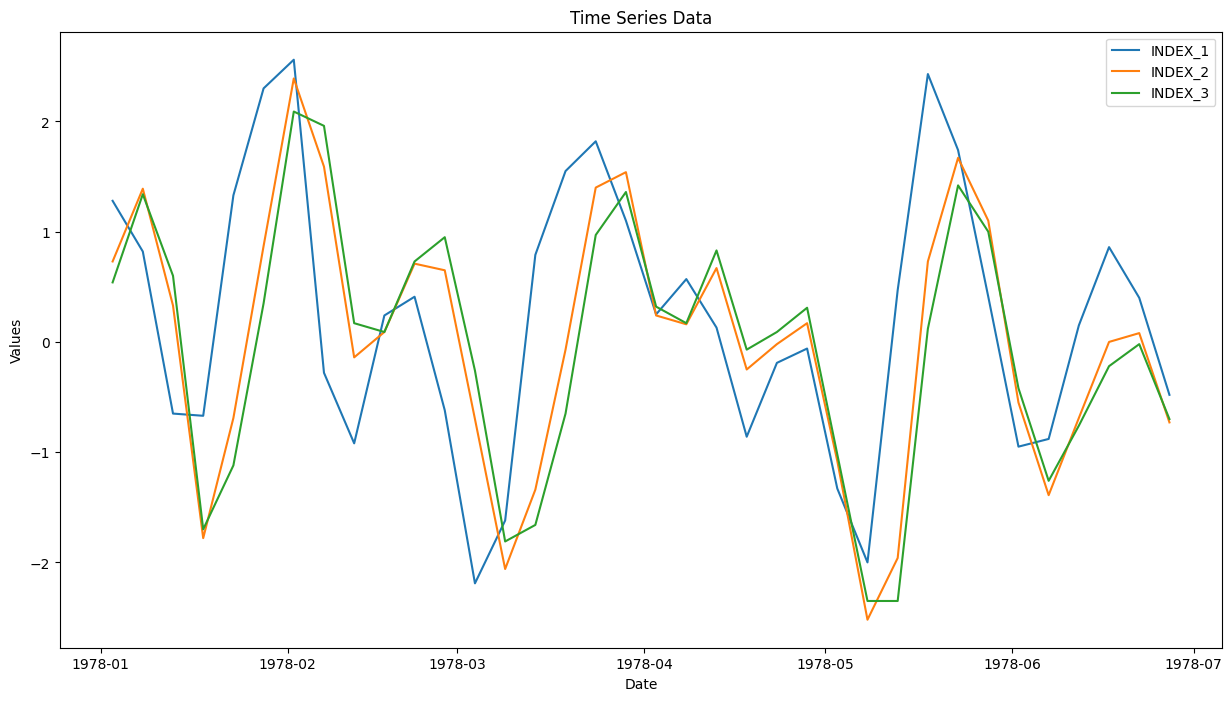

In [19]:
import matplotlib.pyplot as plt
mjo_df = teleconnections.read_mjo_data("1978-07-01")
mjo_df['DATE'] = pd.to_datetime(mjo_df['DATE'])
mjo_df.set_index('DATE', inplace = True)
plt.figure(figsize=(15, 8))  # Adjust the size as needed
for column in mjo_df[['INDEX_1','INDEX_2','INDEX_3']].columns:
    plt.plot(mjo_df.index, mjo_df[column], label=column)

plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
# Graph shows MJO indexes are all very much correlated but lagging. Highly seasonal as well, with a season lasting 1 - 2 months. Put in a 3 month (18 reading) rolling window.

In [20]:
mjo_df = teleconnections.read_mjo_data("2023-11-01")
mjo_df['DATE'] = pd.to_datetime(mjo_df['DATE'])
mjo_df.set_index('DATE', inplace = True)
def extract_MJO_rw(main_df, mjo_df, window_size = 18):
    rolling_windows = {}
    for date in main_df['issue_date']:
        closest_date = mjo_df.index[mjo_df.index <= date].max()
    # Extract the rolling window
        end_idx = mjo_df.index.get_loc(closest_date)
        start_idx = max(end_idx - window_size + 1, 0)  # Ensure start index is not negative
        window = mjo_df.iloc[start_idx:end_idx+1]

        rolling_windows[date] = list(window)
    return rolling_windows
mjo_ind1 = mjo_df['INDEX_1'].interpolate(inplace=False)
mjo_dict = extract_MJO_rw(df_scaled, mjo_ind1)
df_scaled['mjo_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in mjo_dict:
        df_scaled.at[ind, 'mjo_rw'] = mjo_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -..."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ..."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.42, 0.34, -0.87, -0.7, -0.61, -1.27, -1.17,..."
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.34, -0.87, -0.7, -0.61, -1.27, -1.17, 0.35,..."


In [21]:
mjo_df

,INDEX_9,INDEX_10,INDEX_1,INDEX_2,INDEX_3,INDEX_4,INDEX_5,INDEX_6,INDEX_7,INDEX_8
DATE,,,,,,,,,,
1978-01-03,0.38,1.01,1.28,0.73,0.54,-0.16,-0.77,-1.22,-1.09,-0.34
1978-01-08,-0.99,-0.27,0.82,1.39,1.34,1.10,0.57,-0.26,-1.18,-1.36
1978-01-13,-1.10,-1.17,-0.65,0.33,0.60,1.03,1.18,0.96,0.14,-0.69
1978-01-18,1.68,0.88,-0.67,-1.78,-1.70,-1.73,-1.25,-0.20,1.25,1.88
1978-01-23,2.29,2.45,1.33,-0.69,-1.12,-2.12,-2.50,-2.07,-0.37,1.40
...,...,...,...,...,...,...,...,...,...,...
2023-10-10,-0.93,-0.10,0.46,0.81,1.01,0.97,0.40,-0.34,-0.81,-1.09
2023-10-15,0.21,0.71,0.91,0.83,0.57,0.09,-0.55,-0.81,-0.72,-0.40
2023-10-20,-0.32,-0.01,0.26,0.36,0.40,0.36,0.12,-0.16,-0.32,-0.40


# Nino Regions Sea Surface Temp

<Axes: >

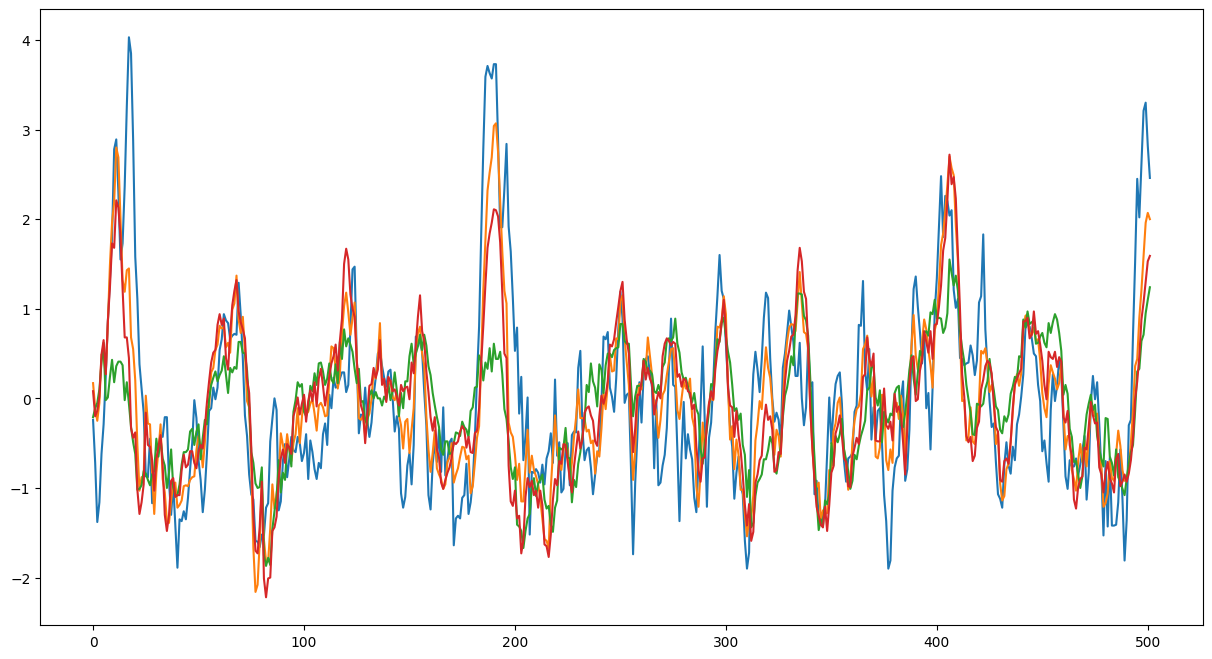

In [22]:
nino_df = teleconnections.read_nino_regions_sst_data("2023-11-01")
plt.figure(figsize=(15, 8))
nino_df['NINO1+2 ANOM'].plot()
nino_df['NINO3 ANOM'].plot()
nino_df['NINO4 ANOM'].plot()
nino_df['NINO3.4 ANOM'].plot()
# Once again, very close, just need one, but use a rolling window once again (Not much seasonality here, so rolling window is just to capture the trend)

In [23]:
def extract_nino_rw(main_df, nino_df):
    nino_df['date'] = pd.to_datetime(nino_df[['YR', 'MON']].assign(DAY=1).rename(columns = {'YR': 'YEAR','MON': 'MONTH'}))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_year = date.year if date.month != 1 else date.year - 1
        end_month = date.month - 1 if date.month != 1 else 12
        start_year = end_year - 1 if end_month != 12 else end_year
        start_month = end_month + 1 if end_month != 12 else 1

        # Create the start and end dates for the window
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1)

        window = nino_df[(nino_df['date'] >= start_date) & (nino_df['date'] <= end_date)]
        window = window['NINO1+2 ANOM']

        rolling_windows[date] = list(window)
    return rolling_windows
nino_dict = extract_nino_rw(df_scaled, nino_df)

df_scaled['nino_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in nino_dict:
        df_scaled.at[ind, 'nino_rw'] = nino_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw,nino_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87...","[-0.23, 0.0, -0.13, -1.25, -1.15, -0.7, -0.51,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -...","[-0.05, 0.25, -0.01, 0.18, -0.29, -0.81, -1.53..."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,..."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.42, 0.34, -0.87, -0.7, -0.61, -1.27, -1.17,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,..."
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.34, -0.87, -0.7, -0.61, -1.27, -1.17, 0.35,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,..."


# ONI

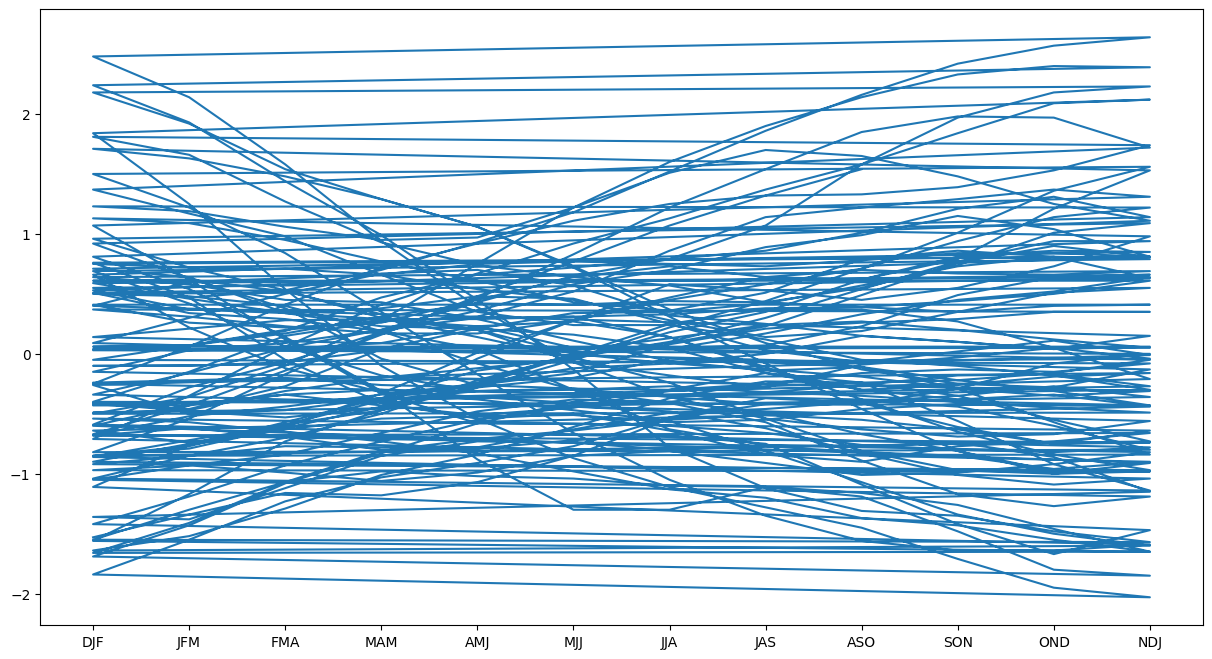

In [24]:
oni_df = teleconnections.read_oni_data("2023-11-01")
plt.figure(figsize=(15, 8))
plt.plot(oni_df.SEAS,oni_df['ANOM'])

In [25]:
seas_mapping = {'NDJ':12, 'DJF':1, 'JFM':2, 'FMA':3, 'MAM':4, 'AMJ':5, 'MJJ':6, 'JJA':7, 'JAS':8, 'ASO':9, 'SON':10, 'OND':11}
oni_df['MON'] = oni_df['SEAS'].map(seas_mapping)
def extract_oni_rw(main_df, oni_df):
    oni_df['date'] = pd.to_datetime(oni_df[['YR', 'MON']].assign(DAY=1).rename(columns = {'YR': 'YEAR','MON': 'MONTH'}))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - relativedelta(months=2)
        start_date = end_date-pd.DateOffset(months = 11)

        window = oni_df[(oni_df['date'] >= start_date) & (oni_df['date'] <= end_date)]
        window = window['ANOM']
        rolling_windows[date] = list(window)
    return rolling_windows
oni_dict = extract_oni_rw(df_scaled, oni_df)
df_scaled['oni_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in oni_dict:
        df_scaled.at[ind, 'oni_rw'] = oni_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw,nino_rw,oni_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0...."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0...."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0...."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0...."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87...","[-0.23, 0.0, -0.13, -1.25, -1.15, -0.7, -0.51,...","[-1.69, -1.43, -1.08, -0.83, -0.58, -0.4, -0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -...","[-0.05, 0.25, -0.01, 0.18, -0.29, -0.81, -1.53...","[-0.48, -0.38, -0.4, -0.49, -0.67, -0.81, -0.9..."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9..."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.42, 0.34, -0.87, -0.7, -0.61, -1.27, -1.17,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9..."
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.34, -0.87, -0.7, -0.61, -1.27, -1.17, 0.35,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9..."


# PDO

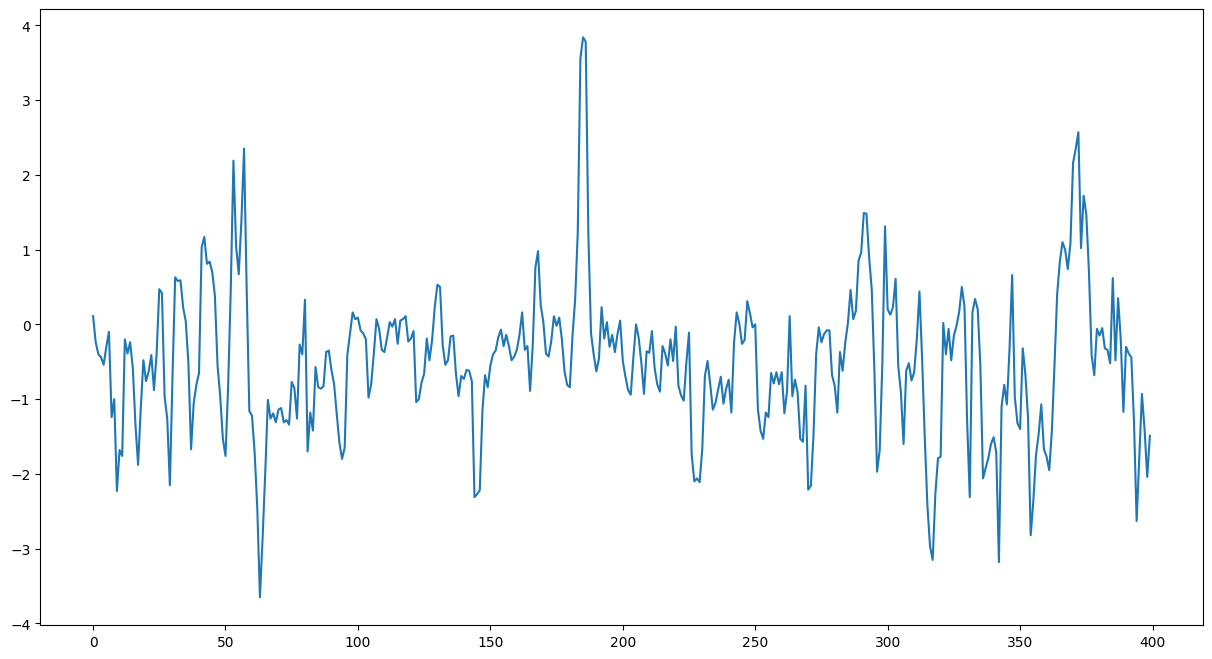

In [26]:
pdo_df = teleconnections.read_pdo_data("2023-11-01")
plt.figure(figsize=(15, 8))
plt.plot(pdo_df['pdo_index'][:400])

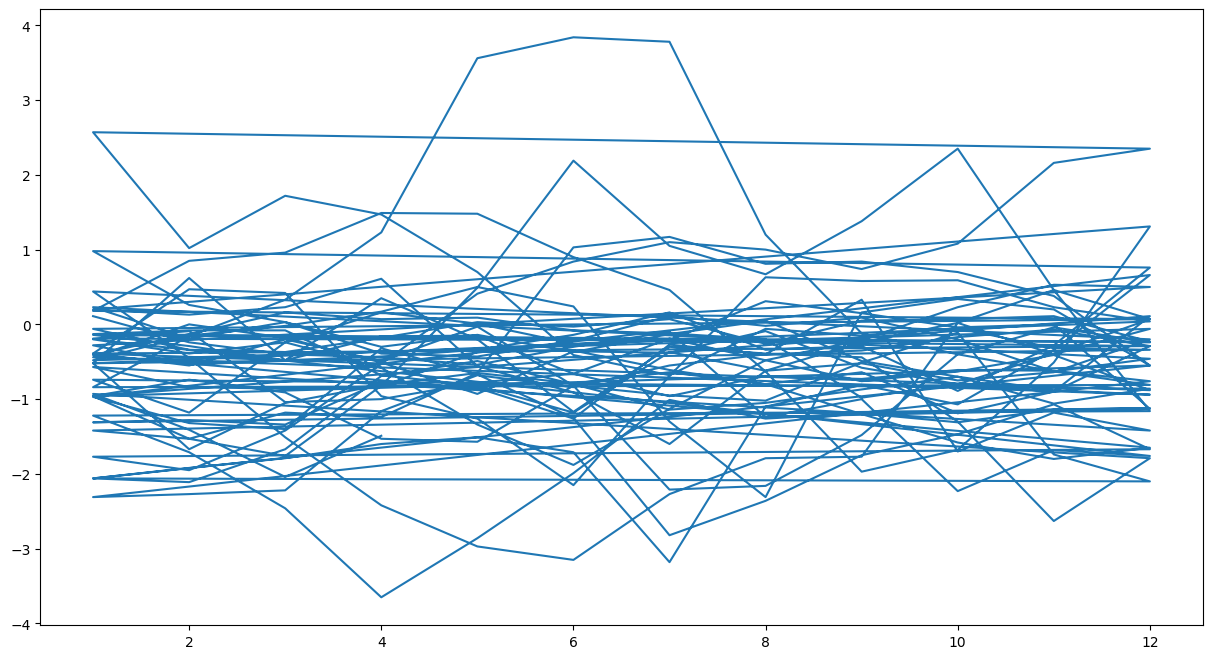

In [27]:
pdo_df = teleconnections.read_pdo_data("2023-11-01")
plt.figure(figsize=(15, 8))
plt.plot(pdo_df.month[:400],pdo_df['pdo_index'][:400])

In [28]:
def extract_pdo_rw(main_df, pdo_df):
    pdo_df['date'] = pd.to_datetime(pdo_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_year = date.year if date.month != 1 else date.year - 1
        end_month = date.month - 1 if date.month != 1 else 12
        start_year = end_year - 1 if end_month != 12 else end_year
        start_month = end_month + 1 if end_month != 12 else 1

        # Create the start and end dates for the window
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1)

        window = pdo_df[(pdo_df['date'] >= start_date) & (pdo_df['date'] <= end_date)]
        window = window['pdo_index']

        rolling_windows[date] = list(window)
    return rolling_windows
pdo_dict = extract_pdo_rw(df_scaled, pdo_df)
df_scaled['pdo_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in pdo_dict:
        df_scaled.at[ind, 'pdo_rw'] = pdo_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw,nino_rw,oni_rw,pdo_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87...","[-0.23, 0.0, -0.13, -1.25, -1.15, -0.7, -0.51,...","[-1.69, -1.43, -1.08, -0.83, -0.58, -0.4, -0.3...","[-1.45, -1.24, -0.32, -0.09, 0.11, 0.56, -0.44..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -...","[-0.05, 0.25, -0.01, 0.18, -0.29, -0.81, -1.53...","[-0.48, -0.38, -0.4, -0.49, -0.67, -0.81, -0.9...","[-1.81, -1.96, -0.94, -1.96, -3.11, -2.75, -2...."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...","[-1.96, -0.94, -1.96, -3.11, -2.75, -2.71, -2...."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.42, 0.34, -0.87, -0.7, -0.61, -1.27, -1.17,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...","[-1.96, -0.94, -1.96, -3.11, -2.75, -2.71, -2...."
17470,yampa_r_nr_maybell,2022,680.923,2022-07-15,0.325856,"[0.25550208959488907, 0.18865546432890581, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.34, -0.87, -0.7, -0.61, -1.27, -1.17, 0.35,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...

# PNA

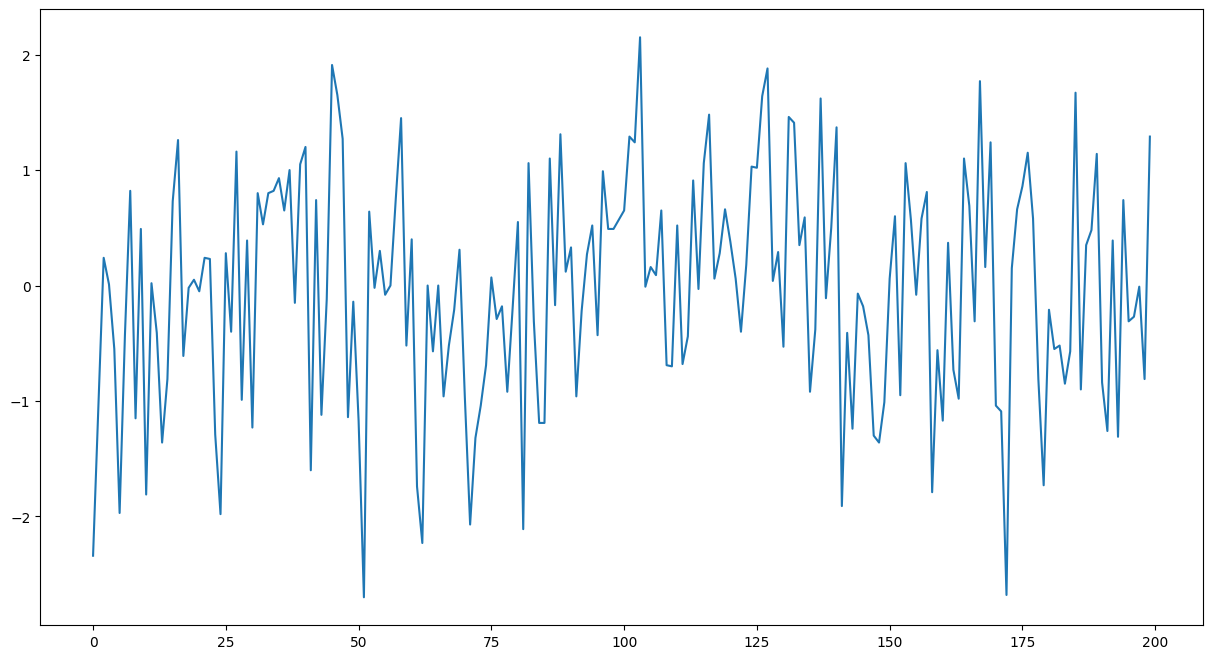

In [29]:
pna_df = teleconnections.read_pna_data("2023-11-01")
plt.figure(figsize=(15, 8))
plt.plot(pna_df['pna_index'][:200])

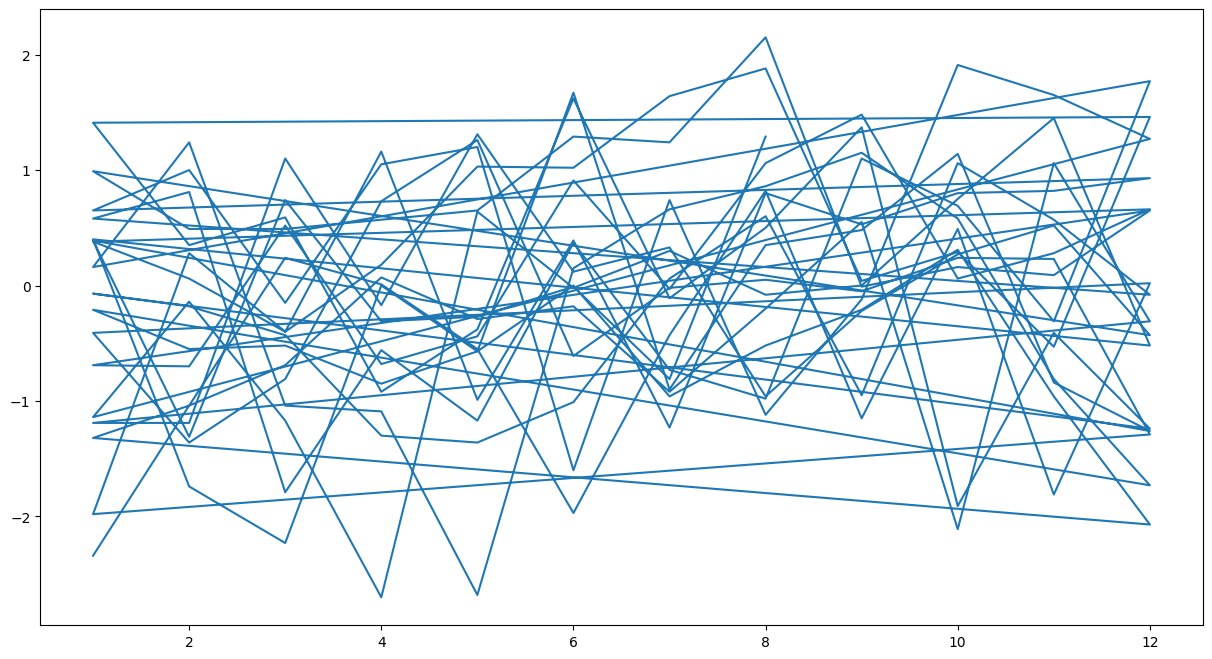

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(pna_df.month[:200],pna_df['pna_index'][:200])

In [31]:
def extract_pna_rw(main_df, pna_df):
    pna_df['date'] = pd.to_datetime(pna_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_year = date.year if date.month != 1 else date.year - 1
        end_month = date.month - 1 if date.month != 1 else 12
        start_year = end_year - 1 if end_month != 12 else end_year
        start_month = end_month + 1 if end_month != 12 else 1

        # Create the start and end dates for the window
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1)

        window = pna_df[(pna_df['date'] >= start_date) & (pna_df['date'] <= end_date)]
        window = window['pna_index']

        rolling_windows[date] = list(window)
    return rolling_windows
pna_dict = extract_pna_rw(df_scaled, pna_df)
df_scaled['pna_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in pna_dict:
        df_scaled.at[ind, 'pna_rw'] = pna_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw,nino_rw,oni_rw,pdo_rw,pna_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87...","[-0.23, 0.0, -0.13, -1.25, -1.15, -0.7, -0.51,...","[-1.69, -1.43, -1.08, -0.83, -0.58, -0.4, -0.3...","[-1.45, -1.24, -0.32, -0.09, 0.11, 0.56, -0.44...","[-1.06, -1.3, -0.54, -0.14, -0.63, -0.18, -0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -...","[-0.05, 0.25, -0.01, 0.18, -0.29, -0.81, -1.53...","[-0.48, -0.38, -0.4, -0.49, -0.67, -0.81, -0.9...","[-1.81, -1.96, -0.94, -1.96, -3.11, -2.75, -2....","[0.67, 0.56, 0.95, 0.44, 1.13, 0.72, -2.56, 1...."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...","[-1.96, -0.94, -1.96, -3.11, -2.75, -2.71, -2....","[0.56, 0.95, 0.44, 1.13, 0.72, -2.56, 1.01, 0...."
17469,yampa_r_nr_maybell,2022,680.923,2022-07-08,0.325856,"[0.3197973169499569, 0.32592067193615387, 0.31...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.42, 0.34, -0.87, -0.7, -0.61, -1.27, -1.17,...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...","[-1.96, -0.94, -1.96, -3.11, -2.75, -2.71, -2.

# SOI

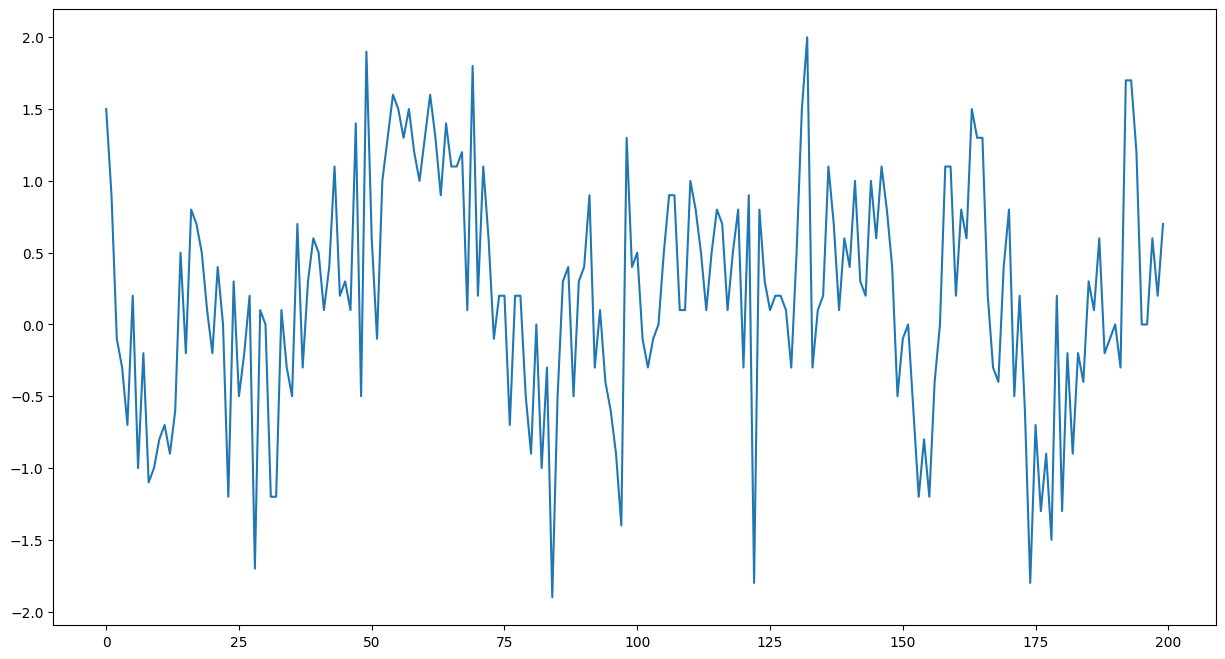

In [32]:
soi_df = teleconnections.read_soi_data("2023-11-01")
plt.figure(figsize=(15, 8))
plt.plot(soi_df['soi'][:200])

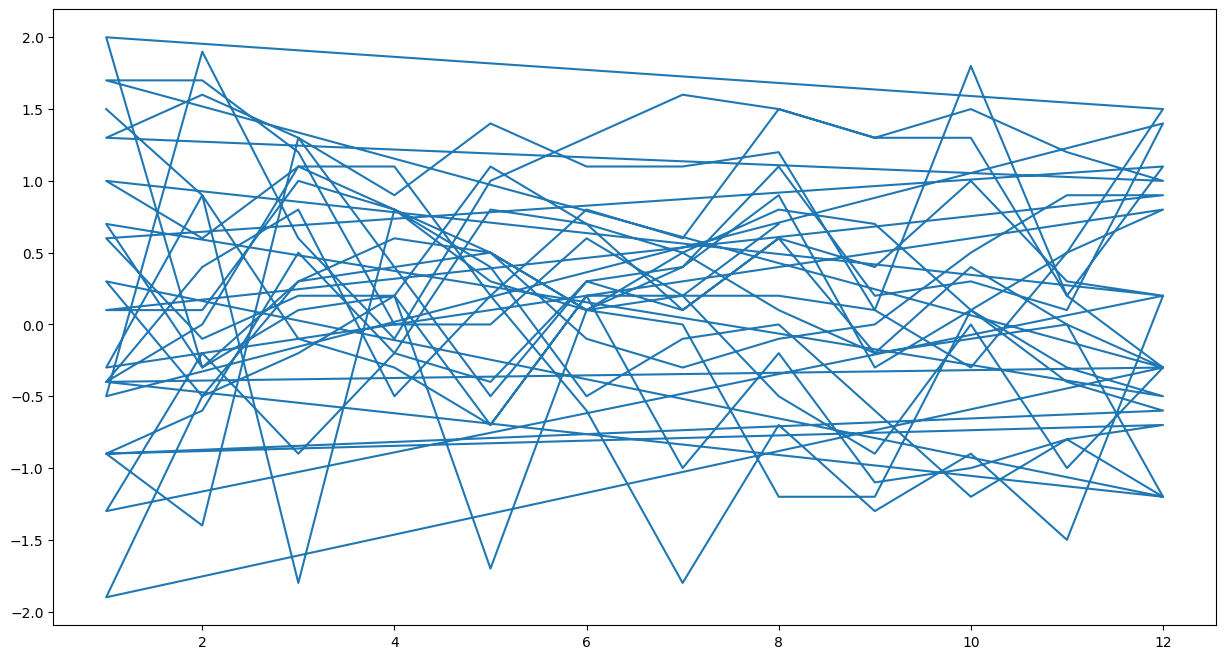

In [33]:
plt.figure(figsize=(15, 8))
plt.plot(soi_df.month[:200],soi_df['soi'][:200])

In [34]:
def extract_soi_rw(main_df, soi_df):
    soi_df['date'] = pd.to_datetime(soi_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_year = date.year if date.month != 1 else date.year - 1
        end_month = date.month - 1 if date.month != 1 else 12
        start_year = end_year - 1 if end_month != 12 else end_year
        start_month = end_month + 1 if end_month != 12 else 1

        # Create the start and end dates for the window
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1)

        window = soi_df[(soi_df['date'] >= start_date) & (soi_df['date'] <= end_date)]
        window = window['soi']

        rolling_windows[date] = list(window)
    return rolling_windows
soi_dict = extract_soi_rw(df_scaled, soi_df)
df_scaled['soi_rw'] = None
for ind, row in df_scaled.iterrows():
    date = row['issue_date']
    if date in soi_dict:
        df_scaled.at[ind, 'soi_rw'] = soi_dict[date]
df_scaled

,site_id,year,volume,issue_date,volume_scaled,usgs_rw,mnf_scaled,mnf_rw,pred_mar,pred_apr,pred_may,pred_jun,pred_jul,mjo_rw,nino_rw,oni_rw,pdo_rw,pna_rw,soi_rw
0,american_river_folsom_lake,1990,532.100,1990-01-01,0.085628,"[0.0028622252420492066, 0.002893983947030845, ...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.5, -0.38, 0.47, 0.73, 1.32, -0.03, -0.64, ...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1...","[1.5, 1.2, 1.1, 1.6, 1.2, 0.7, 0.9, -0.3, 0.5,..."
1,american_river_folsom_lake,1990,532.100,1990-01-08,0.085628,"[0.0027386981453826754, 0.0026116633254561206,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.47, 0.73, 1.32, -0.03, -0.64, -1.22, -0.63,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1...","[1.5, 1.2, 1.1, 1.6, 1.2, 0.7, 0.9, -0.3, 0.5,..."
2,american_river_folsom_lake,1990,532.100,1990-01-15,0.085628,"[0.0022214959691747344, 0.0021420992067206373,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[0.73, 1.32, -0.03, -0.64, -1.22, -0.63, 0.46,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1...","[1.5, 1.2, 1.1, 1.6, 1.2, 0.7, 0.9, -0.3, 0.5,..."
3,american_river_folsom_lake,1990,532.100,1990-01-22,0.085628,"[0.0018314828817957956, 0.0018156035293049762,...",0.097819,"[0.03172846549634365, 0.04688166447469881, 0.0...",0.114502,0.125828,0.084614,0.082711,0.031674,"[1.32, -0.03, -0.64, -1.22, -0.63, 0.46, 0.56,...","[-0.48, -0.23, 0.0, -0.13, -1.25, -1.15, -0.7,...","[-1.85, -1.69, -1.43, -1.08, -0.83, -0.58, -0....","[-1.24, -1.45, -1.24, -0.32, -0.09, 0.11, 0.56...","[-0.72, -1.06, -1.3, -0.54, -0.14, -0.63, -0.1...","[1.5, 1.2, 1.1, 1.6, 1.2, 0.7, 0.9, -0.3, 0.5,..."
4,american_river_folsom_lake,1990,532.100,1990-02-01,0.085628,"[0.0015774132419426855, 0.0015003400544524373,...",0.061772,"[0.04688166447469881, 0.057554633545957676, 0....",0.114502,0.125828,0.084614,0.082711,0.031674,"[-0.64, -1.22, -0.63, 0.46, 0.56, -0.31, -0.87...","[-0.23, 0.0, -0.13, -1.25, -1.15, -0.7, -0.51,...","[-1.69, -1.43, -1.08, -0.83, -0.58, -0.4, -0.3...","[-1.45, -1.24, -0.32, -0.09, 0.11, 0.56, -0.44...","[-1.06, -1.3, -0.54, -0.14, -0.63, -0.18, -0.2...","[1.2, 1.1, 1.6, 1.2, 0.7, 0.9, -0.3, 0.5, 0.8,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,yampa_r_nr_maybell,2022,680.923,2022-06-22,0.325856,"[0.2350909063075659, 0.19937133555475045, 0.17...",0.155663,"[0.017243066692590858, 0.05901254930924646, 0....",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.74, 0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -...","[-0.05, 0.25, -0.01, 0.18, -0.29, -0.81, -1.53...","[-0.48, -0.38, -0.4, -0.49, -0.67, -0.81, -0.9...","[-1.81, -1.96, -0.94, -1.96, -3.11, -2.75, -2....","[0.67, 0.56, 0.95, 0.44, 1.13, 0.72, -2.56, 1....","[0.4, 1.4, 0.6, 0.8, 0.7, 1.0, 1.5, 0.5, 1.1, ..."
17468,yampa_r_nr_maybell,2022,680.923,2022-07-01,0.325856,"[0.22335447591735513, 0.19222742140418736, 0.1...",0.025318,"[0.05901254930924646, 0.20427827444061816, 0.1...",0.017243,0.059013,0.204278,0.155663,0.025318,"[0.26, -0.84, 0.42, 0.34, -0.87, -0.7, -0.61, ...","[0.25, -0.01, 0.18, -0.29, -0.81, -1.53, -0.7,...","[-0.38, -0.4, -0.49, -0.67, -0.81, -0.98, -0.9...","[-1.96, -0.94, -1.96, -3.11, -2.75, -2.71, -2....","[0.56, 0.95, 0.44, 1.13, 0.72, -2.56, 1.01, 0....","[1.4, 0.6, 0.8, 0.7, 1.0, 1.5, 0.5, 1.1, 1.8, ..."
17469,yampa_r_nr_maybell,2022,680.923,2022-0

# Export Data

In [35]:
df_scaled.to_csv('train_processed.csv', index = False)

# Test data

In [36]:
test_df = pd.read_csv('./data/submission_format.csv')
test_df['issue_date'] = pd.to_datetime(test_df['issue_date'])
test_df

,site_id,issue_date,volume_10,volume_50,volume_90
0,hungry_horse_reservoir_inflow,2005-01-01,0.0,0.0,0.0
1,hungry_horse_reservoir_inflow,2005-01-08,0.0,0.0,0.0
2,hungry_horse_reservoir_inflow,2005-01-15,0.0,0.0,0.0
3,hungry_horse_reservoir_inflow,2005-01-22,0.0,0.0,0.0
4,hungry_horse_reservoir_inflow,2005-02-01,0.0,0.0,0.0
...,...,...,...,...,...
7235,owyhee_r_bl_owyhee_dam,2023-06-22,0.0,0.0,0.0
7236,owyhee_r_bl_owyhee_dam,2023-07-01,0.0,0.0,0.0
7237,owyhee_r_bl_owyhee_dam,2023-07-08,0.0,0.0,0.0
7238,owyhee_r_bl_owyhee_dam,2023-07-15,0.0,0.0,0.0


In [37]:
test_df['usgs_rw'] = test_df.apply(lambda row: get_rolling_window(row, usgs_df), axis=1)
test_df

,site_id,issue_date,volume_10,volume_50,volume_90,usgs_rw
0,hungry_horse_reservoir_inflow,2005-01-01,0.0,0.0,0.0,"[0.07350602135878209, 0.07407407407407408, 0.0..."
1,hungry_horse_reservoir_inflow,2005-01-08,0.0,0.0,0.0,"[0.07577823221995002, 0.076346284935242, 0.075..."
2,hungry_horse_reservoir_inflow,2005-01-15,0.0,0.0,0.0,"[0.14224039990911158, 0.14280845262440356, 0.1..."
3,hungry_horse_reservoir_inflow,2005-01-22,0.0,0.0,0.0,"[0.07464212678936606, 0.07521017950465804, 0.0..."
4,hungry_horse_reservoir_inflow,2005-02-01,0.0,0.0,0.0,"[0.0786184957964099, 0.07691433765053397, 0.07..."
...,...,...,...,...,...,...
7235,owyhee_r_bl_owyhee_dam,2023-06-22,0.0,0.0,0.0,"[0.01703534197813374, 0.01703534197813374, 0.0..."
7236,owyhee_r_bl_owyhee_dam,2023-07-01,0.0,0.0,0.0,"[0.01686583608780405, 0.016950589032968894, 0...."
7237,owyhee_r_bl_owyhee_dam,2023-07-08,0.0,0.0,0.0,"[0.014153741842529028, 0.014153741842529028, 0..."
7238,owyhee_r_bl_owyhee_dam,2023-07-15,0.0,0.0,0.0,"[0.014323247732858717, 0.014408000678023562, 0..."


In [38]:
test_mnf = pd.read_csv('./data/test_monthly_naturalized_flow.csv')
test_mnf = test_mnf[test_mnf['forecast_year'] >= 1990]
test_years = test_df['issue_date'].dt.year.unique()
for site_id in test_mnf['site_id'].unique():
    site_data = test_mnf[test_mnf['site_id'] == site_id]  # Filter data for the current site_id

    min_vol = volume_dict[site_id]['min_vol']
    max_vol = volume_dict[site_id]['max_vol']
    # Reshape data for scaling
    volumes = site_data['volume']

    # Fit and transform the data
    scaled_volumes = volumes/max_vol

    # You can replace the original volume data in the DataFrame if desired
    test_mnf.loc[test_mnf['site_id'] == site_id, 'volume'] = scaled_volumes

test_nested_dict = {}
for ind, row in test_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    volume = row['volume']
    

    if site_id not in test_nested_dict:
        test_nested_dict[site_id] = {}
    if year not in test_nested_dict[site_id]:
        test_nested_dict[site_id][year] = {}

    test_nested_dict[site_id][year][month] = volume

all_site_ids = list(test_df['site_id'].unique())
mnf_site_ids = list(test_mnf['site_id'].unique())
missing_ids = [site for site in all_site_ids if site not in mnf_site_ids]
# create a scaffold dictionary with year, month, and NA values
scaffold_dict = copy.deepcopy(test_nested_dict[mnf_site_ids[0]])
for key, inner_dict in scaffold_dict.items():
    for inner_key in inner_dict:
        inner_dict[inner_key] = np.nan

# add scaffold dict to all streams with no monthly naturalized flow
for site_id in missing_ids:
    test_nested_dict[site_id] = scaffold_dict
for year in test_years:
    test_nested_dict['detroit_lake_inflow'][year][6] = np.nan      
rows = []
for site_id, year_data in test_nested_dict.items():
    for year, month_data in year_data.items():
        for month, volume in month_data.items():
            if month > 7:
                forecast_year = year+1
            else:
                forecast_year = year
            rows.append({'site_id': site_id,'forecast_year': forecast_year, 'year': year, 'month': month, 'volume': volume})
full_test_mnf = pd.DataFrame(rows).sort_values(by=['site_id','year','month'])            

for ind, row in full_test_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    if pd.isna(row['volume']):
        lst = []
        site_lst = loc_dict[site_id]
        for site in site_lst:
            if not pd.isna(test_nested_dict[site][year][month]):
                lst.append(test_nested_dict[site][year][month])
            if len(lst) > 3:
                break
        vol = np.mean(lst)
        full_test_mnf.at[ind, 'volume'] = vol
# Obtain the dictionary of the dataframe for faster access again
test_nested_dict = {}
for ind, row in full_test_mnf.iterrows():
    site_id = row['site_id']
    year = row['year']
    month = row['month']
    volume = row['volume']
    forecast_year = row['forecast_year']

    if site_id not in test_nested_dict:
        test_nested_dict[site_id] = {}
    if forecast_year not in test_nested_dict[site_id]:
        test_nested_dict[site_id][forecast_year] = {}

    test_nested_dict[site_id][forecast_year][month] = volume

# def month_calc(month,n):
#     return (month-n-1)%12+1
# mon_rows = []
# rows = []
# for ind, row in test_df.iterrows():
#     site_id = row['site_id']
#     year = row['issue_date'].year
#     month = row['issue_date'].month
#     m_3 = test_nested_dict[site_id][year][month_calc(month,3)]
#     m_2 = test_nested_dict[site_id][year][month_calc(month,2)]
#     m_1 = test_nested_dict[site_id][year][month_calc(month,1)]
#     rw_month = [m_3,m_2,m_1]
#     rows.append(rw_month)
#     mon_rows.append(test_nested_dict[site_id][year][month])
# test_df['mnf_scaled'] = mon_rows
# test_df['mnf_rw'] = rows
def month_calc(month,n):
    return (month-n-1)%12+1
mon_rows = []
rows = []
pred_mar = []
pred_apr = []
pred_may = []
pred_jun = []
pred_jul = []
for ind, row in test_df.iterrows():
    site_id = row['site_id']
    year = row['issue_date'].year
    month = row['issue_date'].month
    m_3 = test_nested_dict[site_id][year][month_calc(month,3)]
    m_2 = test_nested_dict[site_id][year][month_calc(month,2)]
    m_1 = test_nested_dict[site_id][year][month_calc(month,1)]
    rw_month = [m_3,m_2,m_1]
    rows.append(rw_month)
    if month != 7:
        mon_rows.append(test_nested_dict[site_id][year][month])
    else:
        mon_rows.append(np.nan)


test_df['mnf_scaled'] = mon_rows
test_df['mnf_rw'] = rows

In [39]:
mjo_df = teleconnections.read_mjo_data("2023-11-01")
mjo_df['DATE'] = pd.to_datetime(mjo_df['DATE'])
mjo_df.set_index('DATE', inplace = True)
def extract_MJO_rw(main_df, mjo_df, window_size = 18):
    rolling_windows = {}
    for date in main_df['issue_date']:
        closest_date = mjo_df.index[mjo_df.index <= date].max()
    # Extract the rolling window
        end_idx = mjo_df.index.get_loc(closest_date)
        start_idx = max(end_idx - window_size + 1, 0)  # Ensure start index is not negative
        window = mjo_df.iloc[start_idx:end_idx+1]

        rolling_windows[date] = list(window)
    return rolling_windows
mjo_ind1 = mjo_df['INDEX_1'].interpolate(inplace=False)
mjo_dict = extract_MJO_rw(test_df, mjo_ind1)
test_df['mjo_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in mjo_dict:
        test_df.at[ind, 'mjo_rw'] = mjo_dict[date]

In [40]:
def extract_nino_rw(main_df, nino_df):
    nino_df['date'] = pd.to_datetime(nino_df[['YR', 'MON']].assign(DAY=1).rename(columns = {'YR': 'YEAR','MON': 'MONTH'}))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - timedelta(days = 1)
        start_date = end_date-pd.DateOffset(months = 12)

        window = nino_df[(nino_df['date'] >= start_date) & (nino_df['date'] <= end_date)]
        window = window['NINO1+2 ANOM']

        rolling_windows[date] = list(window)
    return rolling_windows
nino_dict = extract_nino_rw(test_df, nino_df)

test_df['nino_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in nino_dict:
        test_df.at[ind, 'nino_rw'] = nino_dict[date]

In [41]:
seas_mapping = {'NDJ':12, 'DJF':1, 'JFM':2, 'FMA':3, 'MAM':4, 'AMJ':5, 'MJJ':6, 'JJA':7, 'JAS':8, 'ASO':9, 'SON':10, 'OND':11}
oni_df['MON'] = oni_df['SEAS'].map(seas_mapping)
def extract_oni_rw(main_df, oni_df):
    oni_df['date'] = pd.to_datetime(oni_df[['YR', 'MON']].assign(DAY=1).rename(columns = {'YR': 'YEAR','MON': 'MONTH'}))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - relativedelta(months=2)
        start_date = end_date-pd.DateOffset(months = 11)

        window = oni_df[(oni_df['date'] >= start_date) & (oni_df['date'] <= end_date)]
        window = window['ANOM']
        rolling_windows[date] = list(window)
    return rolling_windows
oni_dict = extract_oni_rw(test_df, oni_df)
test_df['oni_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in oni_dict:
        test_df.at[ind, 'oni_rw'] = oni_dict[date]

In [42]:
def extract_pdo_rw(main_df, pdo_df):
    pdo_df['date'] = pd.to_datetime(pdo_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - timedelta(days = 1)
        start_date = end_date-pd.DateOffset(months = 12)

        window = pdo_df[(pdo_df['date'] >= start_date) & (pdo_df['date'] <= end_date)]
        window = window['pdo_index']

        rolling_windows[date] = list(window)
    return rolling_windows
pdo_dict = extract_pdo_rw(test_df, pdo_df)
test_df['pdo_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in pdo_dict:
        test_df.at[ind, 'pdo_rw'] = pdo_dict[date]

In [43]:
def extract_pna_rw(main_df, pna_df):
    pna_df['date'] = pd.to_datetime(pna_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - timedelta(days = 1)
        start_date = end_date-pd.DateOffset(months = 12)

        window = pna_df[(pna_df['date'] >= start_date) & (pna_df['date'] <= end_date)]
        window = window['pna_index']

        rolling_windows[date] = list(window)
    return rolling_windows
pna_dict = extract_pna_rw(test_df, pna_df)
test_df['pna_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in pna_dict:
        test_df.at[ind, 'pna_rw'] = pna_dict[date]

In [44]:
def extract_soi_rw(main_df, soi_df):
    soi_df['date'] = pd.to_datetime(soi_df[['year', 'month']].assign(DAY=1))
    rolling_windows = {}
    for date in main_df['issue_date']:
        end_date = datetime(date.year, date.month, 1) - timedelta(days = 1)
        start_date = end_date-pd.DateOffset(months = 12)

        window = soi_df[(soi_df['date'] >= start_date) & (soi_df['date'] <= end_date)]
        window = window['soi']

        rolling_windows[date] = list(window)
    return rolling_windows
soi_dict = extract_soi_rw(test_df, soi_df)
test_df['soi_rw'] = None
for ind, row in test_df.iterrows():
    date = row['issue_date']
    if date in soi_dict:
        test_df.at[ind, 'soi_rw'] = soi_dict[date]
test_df

,site_id,issue_date,volume_10,volume_50,volume_90,usgs_rw,mnf_scaled,mnf_rw,mjo_rw,nino_rw,oni_rw,pdo_rw,pna_rw,soi_rw
0,hungry_horse_reservoir_inflow,2005-01-01,0.0,0.0,0.0,"[0.07350602135878209, 0.07407407407407408, 0.0...",0.050192,"[0.037790486675308835, 0.03420793947373866, 0....","[1.68, 1.03, 0.28, -1.14, -2.39, -1.6, -0.31, ...","[0.28, 0.12, -0.78, -0.02, -0.97, -0.94, -0.75...","[0.35, 0.37, 0.31, 0.23, 0.17, 0.17, 0.28, 0.4...","[-0.55, -0.21, -0.15, -0.0, 0.61, -0.11, 0.04,...","[0.41, 1.06, 0.3, 0.51, -1.76, -0.37, 0.09, 1....","[-1.3, 1.2, 0.4, -0.9, 1.0, -0.8, -0.5, -0.3, ..."
1,hungry_horse_reservoir_inflow,2005-01-08,0.0,0.0,0.0,"[0.07577823221995002, 0.076346284935242, 0.075...",0.050192,"[0.037790486675308835, 0.03420793947373866, 0....","[0.28, -1.14, -2.39, -1.6, -0.31, -0.28, -0.19...","[0.28, 0.12, -0.78, -0.02, -0.97, -0.94, -0.75...","[0.35, 0.37, 0.31, 0.23, 0.17, 0.17, 0.28, 0.4...","[-0.55, -0.21, -0.15, -0.0, 0.61, -0.11, 0.04,...","[0.41, 1.06, 0.3, 0.51, -1.76, -0.37, 0.09, 1....","[-1.3, 1.2, 0.4, -0.9, 1.0, -0.8, -0.5, -0.3, ..."
2,hungry_horse_reservoir_inflow,2005-01-15,0.0,0.0,0.0,"[0.14224039990911158, 0.14280845262440356, 0.1...",0.050192,"[0.037790486675308835, 0.03420793947373866, 0....","[-1.14, -2.39, -1.6, -0.31, -0.28, -0.19, -0.9...","[0.28, 0.12, -0.78, -0.02, -0.97, -0.94, -0.75...","[0.35, 0.37, 0.31, 0.23, 0.17, 0.17, 0.28, 0.4...","[-0.55, -0.21, -0.15, -0.0, 0.61, -0.11, 0.04,...","[0.41, 1.06, 0.3, 0.51, -1.76, -0.37, 0.09, 1....","[-1.3, 1.2, 0.4, -0.9, 1.0, -0.8, -0.5, -0.3, ..."
3,hungry_horse_reservoir_inflow,2005-01-22,0.0,0.0,0.0,"[0.07464212678936606, 0.07521017950465804, 0.0...",0.050192,"[0.037790486675308835, 0.03420793947373866, 0....","[-2.39, -1.6, -0.31, -0.28, -0.19, -0.9, -0.93...","[0.28, 0.12, -0.78, -0.02, -0.97, -0.94, -0.75...","[0.35, 0.37, 0.31, 0.23, 0.17, 0.17, 0.28, 0.4...","[-0.55, -0.21, -0.15, -0.0, 0.61, -0.11, 0.04,...","[0.41, 1.06, 0.3, 0.51, -1.76, -0.37, 0.09, 1....","[-1.3, 1.2, 0.4, -0.9, 1.0, -0.8, -0.5, -0.3, ..."
4,hungry_horse_reservoir_inflow,2005-02-01,0.0,0.0,0.0,"[0.0786184957964099, 0.07691433765053397, 0.07...",0.029020,"[0.03420793947373866, 0.03973546692170584, 0.0...","[-0.31, -0.28, -0.19, -0.9, -0.93, -0.27, 0.72...","[0.12, -0.78, -0.02, -0.97, -0.94, -0.75, -0.6...","[0.37, 0.31, 0.23, 0.17, 0.17, 0.28, 0.47, 0.6...","[-0.21, -0.15, -0.0, 0.61, -0.11, 0.04, 0.24, ...","[1.06, 0.3, 0.51, -1.76, -0.37, 0.09, 1.55, -0...","[1.2, 0.4, -0.9, 1.0, -0.8, -0.5, -0.3, -0.3, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,owyhee_r_bl_owyhee_dam,2023-06-22,0.0,0.0,0.0,"[0.01703534197813374, 0.01703534197813374, 0.0...",0.076305,"[0.10317582841704802, 0.2993648343165904, 0.17...","[-1.02, 0.2, 0.35, 1.29, 1.72, 0.99, -1.11, -1...","[-1.41, -1.16, -0.57, -1.12, -1.81, -1.36, -0....","[-0.99, -0.85, -0.81, -0.91, -1.01, -0.99, -0....","[-1.34, -2.62, -2.38, -2.29, -1.8, -2.41, -2.2...","[-0.31, 2.54, 0.79, 0.21, 0.17, -0.73, -0.66, ...","[1.7, 0.8, 1.0, 1.6, 1.7, 0.3, 2.1, 1.4, 1.4, ..."
7236,owyhee_r_bl_owyhee_dam,2023-07-01,0.0,0.0,0.0,"[0.01686583608780405, 0.016950589032968894, 0....",NaN,"[0.2993648343165904, 0.1790174780834758, 0.076...","[0.2, 0.35, 1.29, 1.72, 0.99, -1.11, -1.21, -0...","[-1.16, -0.57, -1.12, -1.81, -1.36, -0.3, -0.2...","[-0.85, -0.81, -0.91, -1.01, -0.99, -0.92, -0....","[-2.62, -2.38, -2.29, -1.8, -2.41, -2.21, -1.2...","[2.54, 0.79, 0.21, 0.17, -0.73, -0.66, 0.21, -...","[0.8, 1.0, 1.6, 1.7, 0.3, 2.1, 1.4, 1.4, 0.2, ..."
7237,owyhee_r_bl_owyhee_dam,2023-07-08,0.0,0.0,0.0,"[0.014153741842529028, 0.014153741842529028, 0...",NaN,"[0.2993648343165904, 0.1790174780834758, 0.076...","[1.29, 1.72, 0.99, -1.11, -1.21, -0.28, 0.31, ...","[-1.16, -0.57, -1.12, -1.81, -1.36, -0.3, -0.2...","[-0.85, -0.81, -0.91, -1.01, -0.99, -0.92, -0....","[-2.62, -2.38, -2.29, -1.8, -2.41, -2.21, -1.2...","[2.54, 0.79, 0.21, 0.17, -0.73, -0.66, 0.21, -...","[0.8, 1.0, 1.6, 1.7, 0.3, 2.1, 1.4, 1.4, 0.2, ..."
723

In [45]:
test_df.to_csv('test_processed.csv', index = False)